# Deeper Networks for Image Classification


## MobileNetV2 Model for MNIST Image Classification

- Code by: Kaviraj Gosaye
- Student ID: 220575371

In [1]:
# GPU details
output = !nvidia-smi
for line in output:
    print(line)
    if line.strip() == "":
        break

Sat May  4 16:17:47 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.22                 Driver Version: 552.22         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
| N/A   50C    P8             14W /  105W |     615MiB /   8192MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import psutil
# Get virtual memory information
virtual_memory = psutil.virtual_memory()
v_mem = virtual_memory.available / (1024 ** 3)

# Print available virtual memory
print("Available virtual memory:", v_mem)

Available virtual memory: 9.004814147949219


### 0. Imports

In [3]:
# import libraries
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import torchvision.ops.misc as misc
from datetime import datetime

### 1. Data Loading and Preprocessing

In [4]:
# transform PIL image to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5), (0.5))])

# load mnist dataset
train_set = torchvision.datasets.MNIST(root='../datasets', train=True, download=True, transform=transform)
test_set = torchvision.datasets.MNIST(root='../datasets', train=False, download=True, transform=transform)
                                    
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False, num_workers=8)

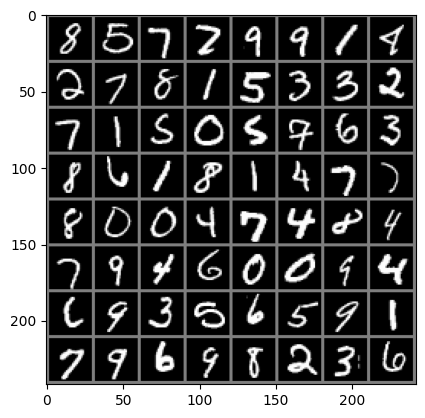

In [5]:
# extract one sample from the training set
dataiter = iter(train_loader)
images, labels = next(dataiter)

# plot the image
def imshow(img):
    # reverse normalization
    img = img / 2 + 0.5
    # convert tensor to numpy array
    npimg = img.numpy()
    # rearrange the dimensions to match matplotlib format
    # matplotlib:   H x W x C
    # torch:        C x H x W
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# show images
imshow(torchvision.utils.make_grid(images))

### 2. Model Building

In [6]:
class InvertedResidual(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual, self).__init__()
        self.stride = stride
        assert stride in [1, 2]

        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = self.stride == 1 and inp == oup

        layers = []
        if expand_ratio != 1:
            layers.append(misc.Conv2dNormActivation(inp, hidden_dim, kernel_size=1, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU6))
        layers.extend([
            misc.Conv2dNormActivation(hidden_dim, hidden_dim, stride=stride, groups=hidden_dim, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU6),
            misc.Conv2dNormActivation(hidden_dim, oup, kernel_size=1, norm_layer=nn.BatchNorm2d, activation_layer=nn.Identity)
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2(nn.Module):
    def __init__(self, num_classes=1000, width_mult=1.0):
        super(MobileNetV2, self).__init__()
        self.cfgs = [
            # t, c, n, s
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1],
        ]

        input_channel = 32
        # change input channels to 1, added padding=1
        layers = [misc.Conv2dNormActivation(1, input_channel, kernel_size=3, stride=2, padding=1, norm_layer=nn.BatchNorm2d, activation_layer=nn.ReLU6)]

        for t, c, n, s in self.cfgs:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel

        self.features = nn.Sequential(*layers)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(input_channel, num_classes)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [7]:
# setting the device to cuda if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [8]:
# creating instance of model and setting it to the device
mobilenetv2 = MobileNetV2(num_classes=10)

In [9]:
# visualize the model
info = summary(mobilenetv2, (1, 1, 28, 28), col_names = ('input_size', 'output_size', 'num_params', 'kernel_size'))
print(info)

Layer (type:depth-idx)                             Input Shape               Output Shape              Param #                   Kernel Shape
MobileNetV2                                        [1, 1, 28, 28]            [1, 10]                   --                        --
├─Sequential: 1-1                                  [1, 1, 28, 28]            [1, 320, 1, 1]            --                        --
│    └─Conv2dNormActivation: 2-1                   [1, 1, 28, 28]            [1, 32, 14, 14]           --                        --
│    │    └─Conv2d: 3-1                            [1, 1, 28, 28]            [1, 32, 14, 14]           288                       [3, 3]
│    │    └─BatchNorm2d: 3-2                       [1, 32, 14, 14]           [1, 32, 14, 14]           64                        --
│    │    └─ReLU6: 3-3                             [1, 32, 14, 14]           [1, 32, 14, 14]           --                        --
│    └─InvertedResidual: 2-2                       [1, 32, 14,

### 3. Model Training and Evaluation

In [10]:
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv2.parameters(), lr=0.0001)

# open log file in write mode
log_file = open("../logs/mobilenetv2_mnist_log.txt", "w")

start = time.time()

num_epochs = 10

train_losses = []
train_accs = []
test_losses = []
test_accs = []

test_correct = 0
total = 0

predicted_labels = []
true_labels = []


for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_train_acc = 0.0
    running_test_loss = 0.0
    running_test_acc = 0.0
    correct = 0.0
    avg_test_loss = 0
    batch_loss = 0.0
    batch_acc = 0.0

    # setting the model to train mode
    mobilenetv2.train()
    
    # loop over the training set
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = mobilenetv2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # cumulative loss
        running_train_loss += loss.item()
        # batch loss for logging
        batch_loss += loss.item()

        # cumulative accuracy
        pred = outputs.argmax(dim=1, keepdim=True)

        # reshaping the labels to match the shape of the predictions
        # comparing the predictions to the labels using element-wise comparison
        # summing the correct predictions
        correct = pred.eq(labels.view_as(pred)).sum().item()
        running_train_acc += 100. * (correct / len(pred))

        # batch accuracy for logging
        batch_acc += 100. * (correct / len(pred))
        # printing the average loss every 100 mini-batches
        if i % 100 == 99:
             # Get current timestamp
            timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            # Write loss to log file
            log_file.write(f"{timestamp} - [{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}\n")
            print(f"[{epoch + 1}, {i + 1}] loss: {batch_loss/100} accuracy: {batch_acc/100}")
            batch_loss = 0.0
            batch_acc = 0.0

    train_accs.append(running_train_acc/len(train_loader))
    train_losses.append(running_train_loss/len(train_loader))


    ##############################

    # setting the model to evaluation mode
    mobilenetv2.to(device)
    mobilenetv2.eval()


    # Disable gradient calculation
    with torch.no_grad():
        # Using test set
        for i, data in enumerate(test_loader, 0):

            images, labels = data[0].to(device), data[1].to(device)
            
            # Forward pass
            outputs = mobilenetv2(images)
            
            # Calculate the test loss
            loss = criterion(outputs, labels)
            avg_test_loss += loss.item()

            # Get the predicted labels
            _, predicted = torch.max(outputs.data, 1)
            
            # Update the total and correct predictions
            total += labels.size(0)
            test_correct += (predicted == labels).sum().item()
            
            # Append the predicted and true labels to be used for confusion matrix
            predicted_labels.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            running_test_loss += loss.item()
            running_test_acc += 100 * test_correct / total

           
        test_losses.append(running_test_loss/len(test_loader))
        test_accs.append(running_test_acc/len(test_loader))

training_time = f'{(time.time() - start)/60.0:.2f}'
log_file.write(f"Finished Training after {training_time} minutes\n")
print(f"Finished Training after {training_time} minutes")

# Close the log file
log_file.close()

[1, 100] loss: 2.2399668288230896 accuracy: 16.984375
[1, 200] loss: 1.99689591050148 accuracy: 29.625
[1, 300] loss: 1.7350639367103577 accuracy: 40.4375
[1, 400] loss: 1.4490383112430572 accuracy: 50.53125
[1, 500] loss: 1.1857598233222961 accuracy: 60.46875
[1, 600] loss: 0.9915136969089509 accuracy: 66.984375
[1, 700] loss: 0.869536896944046 accuracy: 71.265625
[1, 800] loss: 0.7531787705421448 accuracy: 74.8125
[1, 900] loss: 0.6400617691874504 accuracy: 79.296875
[2, 100] loss: 0.5381836706399917 accuracy: 82.875
[2, 200] loss: 0.49414539396762847 accuracy: 83.953125
[2, 300] loss: 0.48584346041083337 accuracy: 84.609375
[2, 400] loss: 0.4314738693833351 accuracy: 86.140625
[2, 500] loss: 0.4344575136899948 accuracy: 86.421875
[2, 600] loss: 0.3977312269806862 accuracy: 87.296875
[2, 700] loss: 0.37745616093277934 accuracy: 88.046875
[2, 800] loss: 0.3714717787504196 accuracy: 88.59375
[2, 900] loss: 0.33587686404585837 accuracy: 89.21875
[3, 100] loss: 0.26951652616262434 accura

In [11]:
# save model after training
torch.save(mobilenetv2, "../Models/mobilenet_v2_mnist.pth")

### 4. Model Results and Plots

In [12]:
# print final accuracy
# get the final value of train_acc

print(f"Train Accuracy: {train_accs[-1]} %")
print(f"Test Accuracy: {test_accs[-1]} %")

print(f"Train Loss: {train_losses[-1]}")
print(f"Test Loss: {test_losses[-1]}")

Train Accuracy: 98.61240671641791 %
Test Accuracy: 94.05990456440809 %
Train Loss: 0.04368516083768031
Test Loss: 0.09918127216882174


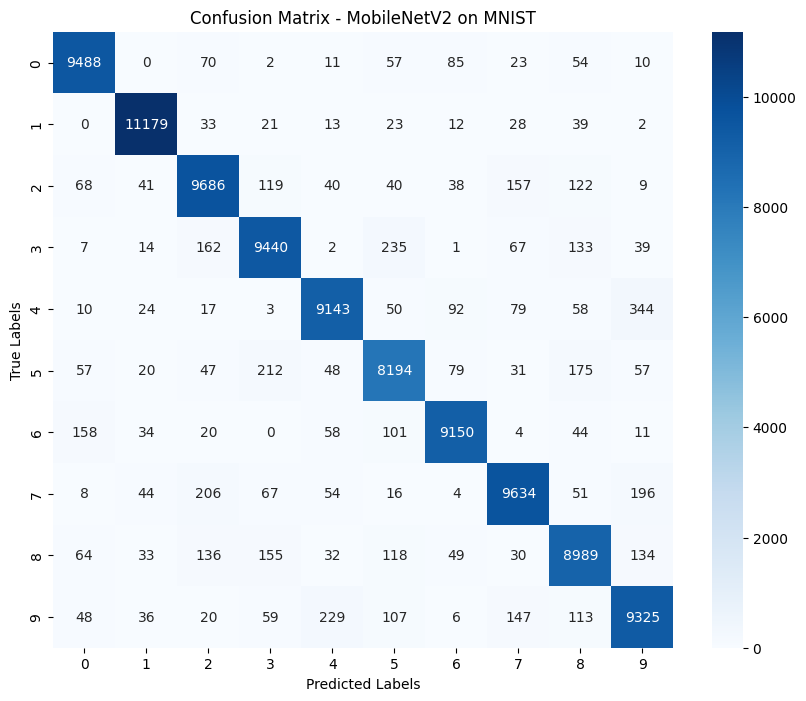

In [13]:
# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - MobileNetV2 on MNIST")
plt.show()

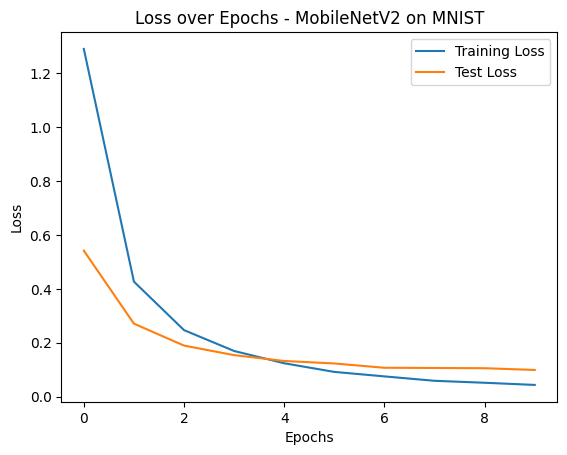

In [14]:
# plot the training loss and test loss over epochs
plt.plot(train_losses, label="Training Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs - MobileNetV2 on MNIST")
plt.legend()
# save the plot
plt.savefig("./plots/Loss_MobileNetV2_MNIST.png")
plt.show()

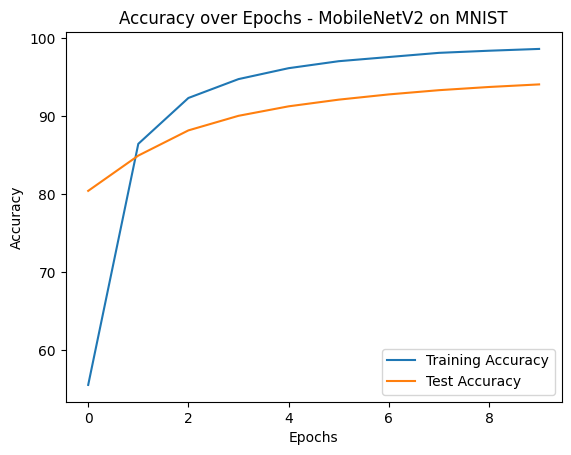

In [15]:
# plot the training accuracy and test accuracy over epochs
plt.plot(train_accs, label="Training Accuracy")
plt.plot(test_accs, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy over Epochs - MobileNetV2 on MNIST")
plt.legend()
plt.savefig("./plots/Acc_MobileNetV2_MNIST.png")
plt.show()

In [16]:
# print classification report
cr = classification_report(true_labels, predicted_labels)
print(cr)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      9800
           1       0.98      0.98      0.98     11350
           2       0.93      0.94      0.94     10320
           3       0.94      0.93      0.94     10100
           4       0.95      0.93      0.94      9820
           5       0.92      0.92      0.92      8920
           6       0.96      0.96      0.96      9580
           7       0.94      0.94      0.94     10280
           8       0.92      0.92      0.92      9740
           9       0.92      0.92      0.92     10090

    accuracy                           0.94    100000
   macro avg       0.94      0.94      0.94    100000
weighted avg       0.94      0.94      0.94    100000



### 5. Model Testing

In [17]:
# loading some images from the test set
testloader = torch.utils.data.DataLoader(test_set, batch_size=30,shuffle=False)

dataiter = iter(testloader)
images, true_labels = next(dataiter)   

In [18]:
# classes of mnist
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [19]:
# plotter function to plot the images
def plotter(images, true_labels, predicted_labels):
    correct = 0
    num_images = len(images)
    num_rows = (num_images) // 5
    fig, axs = plt.subplots(num_rows, 5, figsize=(15, 20))
    # setting the title
    fig.suptitle('True Label - [Predicted Labels]', fontsize=20)

    for ind in range(num_images):
        # plot image
        img = images[ind].permute(1, 2, 0) / 2 + 0.5
        ax = axs[ind // 5, ind % 5]
        ax.imshow(img, cmap='gray')

        # left - true label, right - predicted label
        if classes[true_labels[ind]] == classes[predicted_labels[ind]]:
            color = 'green'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)
            correct += 1
        else:
            color = 'red'
            title = classes[true_labels[ind]] + ' - [' + classes[predicted_labels[ind]] + ']'
            ax.set_title(title, color=color)        

    plt.tight_layout(pad=2.0)
    plt.show()
    print('Number of correct predictions: ', correct)
    print('Number of wrong predictions: ', num_images - correct)

In [20]:
# use model to predict images label
mobilenetv2.eval()
mobilenetv2.to('cpu')
outputs = mobilenetv2(images)
_, predicted_labels = torch.max(outputs, 1)

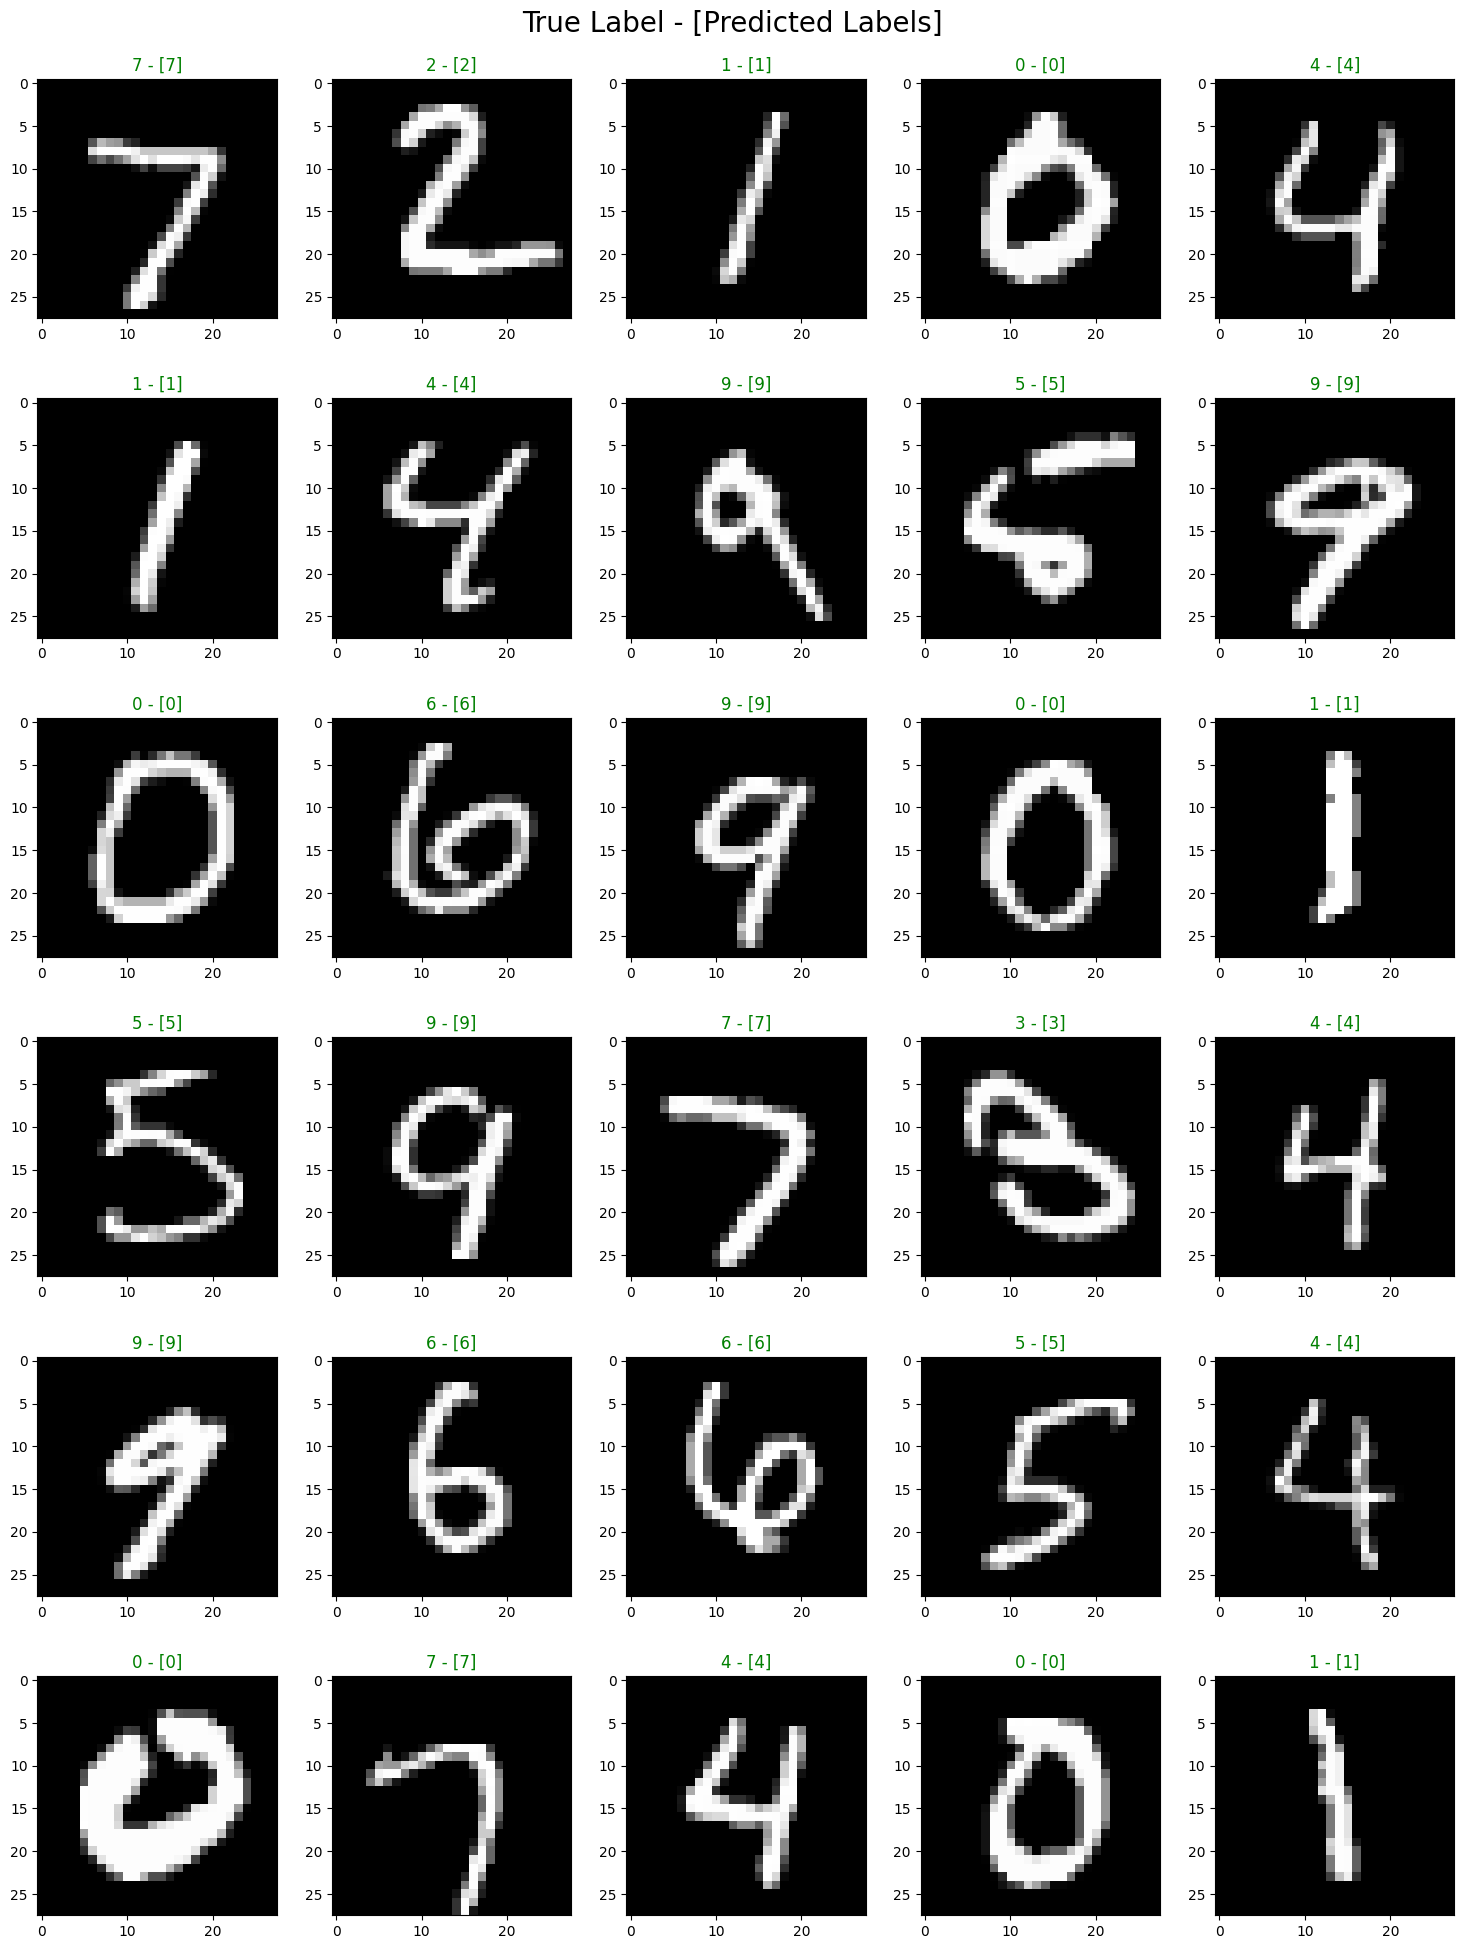

Number of correct predictions:  30
Number of wrong predictions:  0


In [21]:
# plot the images and predictions
plotter(images, true_labels, predicted_labels)